Introduction
=======

Expressions in **Prove-It** are fundamental and versatile.  In order to prove some statement, you must be able to express the statement that you want to prove, and express each axiom and each theorem that is used to construct the proof as well as intermediate statements along the way.  Statements and proofs will be discussed in later tutorials.  Here we focus on the expressions themselves.  In **Prove-It**, an expression is a tree-like data structure (technically a directed acyclic graph, DAG, since there may be multiple instances of the same sub-expression).  As a Python object, its base class is **proveit.\_core\_.expr.Expression** (also aliased as proveit.Expression via "from ... import ..." statements within **\_\_init\_\_.py** files).  It must have an intermediate class in the class inheritance hierarchy that is one of the "core" **Expression** classes which governs how the expression behaves when used in a proof (specifically governing the **specialize** derivation step which will be discussed in subsequent tutorials).  

In the **Prove-It** philosophy, expression representations should be explicit, not implicit.  To this end, the external representation of how an expression is displayed should be a true reflection of its internal representation (with some caveats regarding **Literal**s that will be discused below).  That way, there is no ambiguity and no confusion.  Rather than exploiting equivalences of expressions implicitly, all transformations are enabled by explicit, traceable axioms.  As a consequence, however, **Prove-It** is not a minimalist approach with respect to types of expressions or with respect to numbers of axioms.  One example is currying.  Named for Haskell Curry, this is a minimalistic way to avoid multi-argument functions by expanding them as nested single-argument functions; however, the **Prove-It** philosophy is to be explicit about using multi-argument operations when one wishes to express statements in that form.

The following are the core **Expression** classes that enable a variety of explicit forms of expressions.  A brief description is provided for each class, but these concepts will become more clear by considering examples shown below.
* **Label**: A label for a mathematical object (e.g., a symbol).
    * **Variable**: A label with no contextual meaning.
    * **MultiVariable**: A placeholder for multiple **Variable**s, indicated with one or more dummy, symbolic indexing **Label**s.
    * **Literal**: A label with contextual meaning that is bound to some *context* (specified as a Python package).
* **Lambda**: Represents a mathematical mapping or function; contains the *arguments* (an **ExpressionList** of **Variable**s or **MultiVariable** **Bundle**s that are being mapped) and an *expression* (any **Expression** that the arguments are to be mapped into).
* **Operation**: Represents an applied operation; contains an *operator* (a **Label** or **Lambda**) and *operands* (a **Composite**).
* **Composite**: An **Expression** that contains multiple **Expression**s in a collection.
    * **ExpressionList**: A 1-dimensional collection of **Expressions**s.
    * **ExpressionTensor**: A multi-dimensional collection of **Expression**s.
    * **NamedExpressions**: Maps keyword strings into **Expression**s.
* **Bundle**: A placeholder for a portion of a **Composite**. 
    * **Etcetera**: A placeholder for a portion of an **ExpressionList**.
    * **Block** A placeholder for a portion of an **ExpressionTensor**.

Developers and users may derive from core **Expression** classes (**Literal** and **Operation** classes in particular) to make their own **Expression** classes that have special formatting rules and methods for manipulating and utilizing the expression.  The formatting should ideally be in direct correspondence with the structure of the **Expression** in regards to core **Expression** classes (a true reflection of the internal representation as stated above), but there is no enforcement mechanism to ensure that this is the case.  Users are advised to inspect the fully explicit expression DAG by calling **exprInfo()** on the **Expression** object, to ensure that the formatting properly reflects the internal content (or rely on crowd-source checking of axioms/theorems).

The remainder of this tutorial will show examples and discuss details of the different core **Expression** classes (types).

As we discuss these different core types we will discuss the instances when different expressions are considered to be the same or different.  This is important because it corresponds to whether or not statements are the same or not, and that is important because a statement is proven if it is the same as another statement that has been proven.

We will also discuss *expression substitution/relabeling* as we go through the different cases.  The following are related but distinct manipulations in **Prove-It**:
* *Expression substutition*: creating a new **Expression** from an existing **Expression** by swapping one or more sub-expression(s) for other sub-expression(s).  This creates a new **Expression** but has nothing to do, intrinsically, with proving statements.
* *Expression relabeling*: a restricted version of *expression substitution* in which any **Variable** may be relabeled only with another **Variable** or any **MultiVariable** may be relabeled with another **MultiVariable** or a list of **Variable**s.
* Statement *specialization*: deriving a statement of the form $P(y)$ from a statement of the form $\forall_x P(x)$.  Details of this will be discussed in a later tutorial, but this manipulation uses *expression substitution* in generating $P(y)$.  However, specific rules and limitations apply to *specialization* that may not apply to *expression substitution* to ensure that the derivation is sound.  It specifically involves statements with the $\forall$ quantifier.
* *Statement relabeling*: deriving a statement from another statement which differs only in its **Variable**s or **MultiVariable**s, or replaces **MultiVariable**s with a list if **Variable**s.  For example, from $\forall_x P(x)$, we could use *relabeling* to derive $\forall_y P(y)$.  It works the same way as *expression relabeling* but is applied in the context of a proof derivation.
* *Equality substitution*: using the **substitution** axiom of **proveit.logic.equality** to prove that $f(x) = f(y)$ given $x = y$.  This uses *statement specialization* of the **substitution** axiom which state $\forall_{f, x, y} ((x = y) \Rightarrow (f(x) = f(y)))$.  This specifically involves statements with the **proveit.logic.equality.eqOps.Equals** **Literal**. This will be discussed in a later tutorial.

The focus here will be *expression substitution/relabeling* with some mention of the additional restrictions applicable to *statement specialization/relabeling*.  It is important to understand the distinction of these three kinds of manipulations.  Reminders will be given throughout the tutorials.

Labels: Variable, MultiVariable, and Literal
================================

In [1]:
from proveit import Label, Variable, MultiVariable, Literal

Label
-----

**Variable**, **MultiVariable**, and **Literal** derive from the **Label** class.

In [2]:
# A Label has a string format and a latex format
triangle = Label(stringFormat='triangle', latexFormat=r'\triangle')
triangle # the latex is processed and displayed in IPython

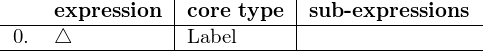

In [3]:
# The Label's expression info shows that it has a core type of Label and no sub-expressions.
triangle.exprInfo() # the expressions and sub-expressions are numbered with the top level being zero.

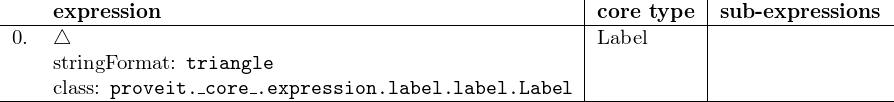

In [4]:
# This information is technically not complete for the purpose of distinguishing expressions.
triangle.exprInfo(details=True) # the string format and class is also important

In [5]:
# Two Label's are regarding to be the same expression iff both formats, and the class, are the same.
print "== when both formats are the same: ", (triangle == Label('triangle', r'\triangle'))
print "== when one format is different: ", (triangle == Label('tri', r'\triangle'))

class Triangle(Label):
    def __init__(self):
        Label.__init__(self, 'triangle', r'\triangle')
print "== when the class is different: ", triangle == Triangle()

== when both formats are the same:  True
== when one format is different:  False
== when the class is different:  False


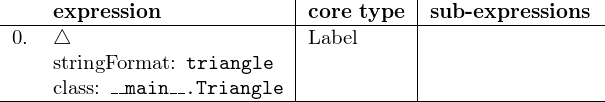

In [6]:
# See that the class difference shows up when displaying expression information with details=True
Triangle().exprInfo(details=True)

In [7]:
# let's make another label to test out substituted and relabeled methods
square =  Label(stringFormat='square', latexFormat=r'\Box')
square

Using *expression substitution*, we can change one **Label** into another or any other **Expression**.  We'll see that *specialize* is more restrictive; only applicable to **Variable**s and not any **Label**, but for *expression substition* this is fine.

In [8]:
triangle.substituted({triangle:square})

Using *expression relabeling*, the **Label** does not change because only **Variable**s and **MultiVariable**s may be relabeled.

In [9]:
triangle.relabeled({triangle:square})

Variable
--------
A **Variable** is an interchangeable label with no formal, contextual meaning.

In [10]:
x = Variable('x') # the string and latex formats are the same by default
x

In [11]:
omega = Variable(stringFormat='omega', latexFormat=r'\omega') # different string and latex format
omega 

As a convention, convenient Variables and Expressions are contained in **common** modules in various packages.  That is, **common** modules hold common expressions:

In [12]:
from proveit.common import a, b, c, x, y, z, alpha
alpha

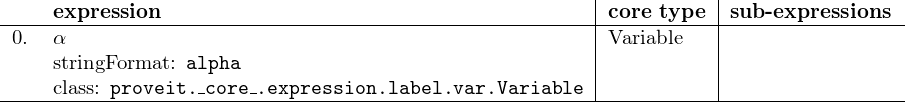

In [13]:
# Expression information is similar to the Label, but with the different core type and class
alpha.exprInfo(details=True)

Just as we saw for the generic **Label** **Expression**s, we can use *expression substitution* to exchange one **Variable** for another or any other **Expression**.  Furthermore, we will see in a later tutorial that **Variable**s have special properties with respect to *specialization* because they are defined as interchangeable labels.

In [14]:
alpha.substituted({alpha:omega})

Unlike generic **Label** **Expression**s, we can use *expression relabeling* to change a **Variable** into a different **Variable**, and only a **Variable**.  **Variable**s have special properties with respect to *relabeling*.

In [15]:
alpha.relabeled({alpha:omega})

In [16]:
from proveit import ImproperRelabeling
try:
    alpha.relabeled({alpha:square})
except ImproperRelabeling:
    print "May only relabel a Variable with a Variable"

May only relabel a Variable with a Variable


MultiVariable
-------------
A **MultiVariable** represents multiple **Variable**s in one **Label**.

In [17]:
r = MultiVariable('r', latexFormat=r'{\vec r}')
r # has a dummy index (box by default) to indicate that it can be expanded to a list of Variables

In [18]:
# Can also be used to represent a multi-dimensional array of Variables
A = MultiVariable('A', numDimensions=2)
A # a box and triangle are used as the multi-dimensional dummy indices

In [19]:
# The default dummy indices may be overridden
B = MultiVariable('B', numDimensions=2, axesLabels=[Label('@', r'\triangle'), Label('*', r'\Box')])
B # switched the triangle and box just to show we can

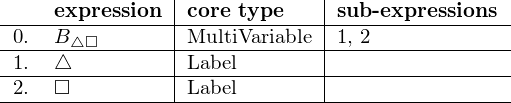

In [20]:
# Looking at B's expression information, we see that the dummy indices are regarded as Label sub-expressions.
B.exprInfo()

With *expression substitution*, a **MultiVariable** may change into a different **MultiVariable** or it will be changed to an **ExpressionList**.

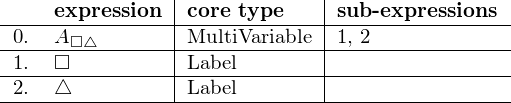

In [21]:
B.relabeled({B:A}).exprInfo()

In [22]:
B.substituted({B:x}).exprInfo()

TypeError: May only substitute a multi-axis MultiVariable with an ExpressionTensor

Except what it is already a list or **ExpressionList** (it will *not* form nested **ExpressionList**s).

In [23]:
B.substituted({B:[x, y, triangle]}).exprInfo()

TypeError: May only substitute a multi-axis MultiVariable with an ExpressionTensor

In [43]:
B.relabeled({B:[x, y, z]})

Literal
-------

A **Literal** is another kind of **Label**.  In contrast to **Variable**s, **Literal**s have a formal, contextual meaning. They are bound to a *context* (as a Python package) and endowed with meaning via axioms as will be discussed later.  Below are different scenarios in which a **Literal** could appropriately be used.  For our example **Literal**s, we will use 'tutorial' as the context.  The context should be set to the full name of the package where the **Literal** is defined. 

### Specific operators

In [15]:
TIMES = Literal(context='tutorial', stringFormat='*', latexFormat=r'\times')
TIMES # By convention, Literal operators are ALL-CAPS

In [16]:
FACTORIAL = Literal('tutorial', '!')
FACTORIAL

In [17]:
SUMMATION = Literal('tutorial', 'sum', r'\sum')
SUMMATION

### Constant values

In [18]:
FIVE = Literal('tutorial', '5')
FIVE

In [19]:
TRUE = Literal('tutorial', 'true', r'\top')
TRUE # By convention, Literal constants are also ALL-CAPS

In [20]:
FALSE = Literal('tutorial', 'false', r'\bot')
FALSE

### Contextual "variables"

This is appropriate when variables are given a specific meaning within the context of a problem.  For example, consider a math "story problem" where Andrea has $a$ apples and Bill has $b$ bananas.  These are variables in a sense, but here they have contextual meaning so they should be **Literal**s.  However, suppose one wants to prove a general theorem for any number of Andrea's apples and Bill's bananas.  One may start by using the $a$ and $b$ **Literal**s for convenience for some contextual "lemmas" (although it should be noted that Prove-It does not distinguish between lemmas and theorems), but then demote them to **Variable**s in order to make a statement of the form $\forall_{a, b} P(a, b)$ (**Literal**s may not be quantified over).  This is done by using a process called axiom elimination that will be discussed later.  For now, we just note that "variables" with contextual meaning need to be **Literal**s.

In [21]:
aLit = Literal('tutorial', 'a')
aLit

In [22]:
bLit = Literal('tutorial', 'b')
bLit

In [23]:
print "== between Variable a and Literal a:", a == aLit

== between Variable a and Literal a: False


There is a potential source of confusion when a **Literal** and a **Variable** are displayed in the same way.  Our solution is for **Prove-It** to check for such mistakes and raise appropriate exceptions that alert the user to the problem.  For example, users will be alerted when attempting to quantify over a **Literal** that there may be such a mix up.  Also, when equivalence is checked between **Expression**s, we check the equivalence when all **Literal**s are converted to their corresponding **Variable**s (with the same string and latex format) to see if that changes the conclusion regarding equivalence. 

### Literal expression comparision

Not only are **Literal**s and **Variabe**s regarded as different **Expression**s even if they have the same formatting, **Literal**s with different contexts are regarded as different even if they have the same formatting.

In [24]:
# Let's rename our 'tutorial' TRUE/FALSE and import TRUE/FALSE from proveit.logic, one of the main context packages
tutorialTrue = TRUE
tutorialFalse = FALSE
from proveit.logic import TRUE, FALSE

In [25]:
# When the context is different, they are not the same.
TRUE == tutorialTrue

False

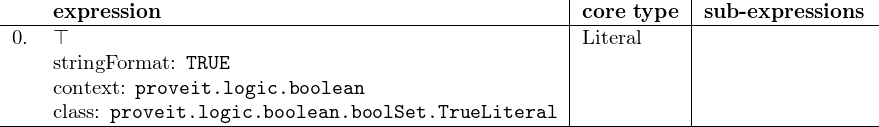

In [26]:
# The detailed expression information reveals the differences.
TRUE.exprInfo(details=True)

Note that the TRUE expression has a different class that the basic **Literal** class.  This is desirable whenever we wish to make special methods that are specific to a particular kind of expression.  In the case of the TRUE and FALSE **Literal**s that we have imported from **proveit.logic**, the **evalEquality** is convenient for invoking any of the following true statements: $\top = \top$, $\bot = \bot$, $\top \neq \bot$, or $\bot \neq \top$ as desired ($\bot \neq \top$ is an axiom and the others are proven theorems within **proveit.logic**).

In [27]:
TRUE.evalEquality(FALSE)

ImportError: No module named expression

Lambda
====

Represents a mathematical mapping or function; contains the *arguments* (an **ExpressionList** of **Variable**s or **MultiVariable** **Bundle**s that are being mapped) and an *expression* (any **Expression** that the arguments are to be mapped into).

In [29]:
from proveit import Lambda

In [30]:
# maps any value to 5
Lambda(x, FIVE) 

In [31]:
# Can have multiple arguments, and the lambda's expression may involve any of these arguments
lambdaExpr = Lambda([x, omega], x)

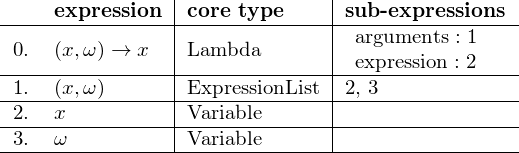

In [34]:
# Expression info shows how the Lambda is broken down into arguments and the expression as sub-expression.
lambdaExpr.exprInfo()

In [33]:
# Can include MultiVariable Bundles
from proveit import Etcetera # More on Etcetera in the Bundle section
Lambda([x, Etcetera(r), omega], omega)

Operation
=========

Represents an applied operation; contains an operator (a Label or Lambda) and operands (a Composite).

In [35]:
from proveit import Operation

In [36]:
# Simple case: a Variable operator with a single Variable operand
f = Variable('f')
fx = Operation(f, x)
fx # f(x)

Common forms of these are available from **proveit.common**:

In [37]:
from proveit.common import fx, gx
gx

In [38]:
# Let's derive a class from Operation for a kind of operation with a specific literal operand.
class Factorial(Operation):
    
    def __init__(self, operand):
        # creates the Operation with FACTORIAL as the operator and the provided operand as its only operand.
        Operation.__init__(self, FACTORIAL, operand)
        self.operand = operand # store this here for convenience
        
    def string(self, **kwargs): # should accept kwargs even when not used (e.g., 'fence')
        # the operand should be fenced (wrapped in parentheses) to prevent ambiguity
        return self.operand.string(fence=True) + self.operator.string()
    
    def latex(self, **kwargs): # should accept kwargs even when not used (e.g., 'fence')
        # the operand should be fenced (wrapped in parentheses) to prevent ambiguity
        return self.operand.latex(fence=True) + self.operator.latex() 

In [39]:
# Now we can make
fiveFactorial = Factorial(FIVE)
fiveFactorial

A **Factorial** is an **Operation** with **FACTORIAL** as the **Literal** operator.  Its formatting is altered from the default but is still true (in a 1-to-1 correspondence) to the core **Expression** structure.

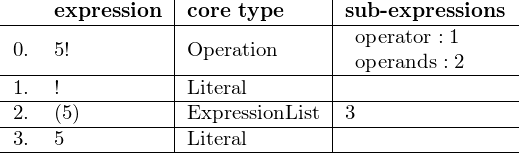

In [41]:
# show core structure
fiveFactorial.exprInfo()

Here, in the IPython notebook setting, we just need the latex formatting, but it is always a good idea to define the string formatting for whenever it is needed.  The `fence=True` above indicates that parentheses should be used when it could be ambiguous otherwise.  Our example above has no ambiguity, so parentheses are not used.  We will show a case below where the parentheses are required.

Now let's consider a multiple operand example.  Internally, this uses an **ExpressionList** that will be discussed in the **Composite** section.  Rather than derictly deriving the class from **Operation**, we'll use **AssociativeOperation** which has default formatting that is applicable for our needs here.

In [42]:
from proveit.logic.genericOps import AssociativeOperation

class Multiply(AssociativeOperation):
    def __init__(self, *operands): # takes a list of arguments as the operands
        # creates the AssociativeOperation with TIMES as the operator and any number of operands.
        AssociativeOperation.__init__(self, TIMES, *operands)

In [43]:
# Demonstrating an Operation with multiple operands
multExpr = Multiply(x, FIVE, omega)
multExpr

In [44]:
# Let's nest Operations and show proper fencing behavior
nestedOperation = Factorial(multExpr)
nestedOperation

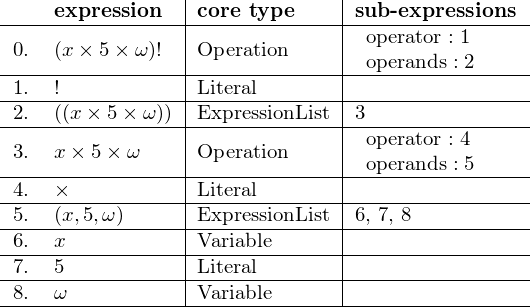

In [45]:
nestedOperation.exprInfo()

TODO: show structure.
Also need to do an example with a Lambda operator

In [48]:
Operation(Lambda(x, FIVE), omega)